# Wstęp do uczenia maszynowego
##  Projekt nr 2
#### Jakub Piwko, Malwina Wojewoda

#### Pakiety

In [18]:
import pandas as pd
#import numpy as np
#from sklearn.cluster import KMeans, AgglomerativeClustering
import matplotlib.pyplot as plt
#import seaborn as sns

### Wczytanie danych oraz ich opis

Jak dowiadujemy się z opisu danych są one obrobioną nieco wersją zbioru USCensus1990raw. Zawierał  on 1 % próbki z pełnego spisu powszechnego z 1990r. W naszym pliku rekordy zostały losowo przemieszane. Aby uzyskać zbiór, którym się zajmujemy zostały wykonane następujące operacje: 
* randomizacja: rekordy z USCensus1990raw zostały losowo permutowane
* zmiany w kolumnach: kilka zmiennych ciągłych zostało zdyskretyzowane, a zmienne dyskretne, które miały dużo wartości zostało zwinięte do mniejszej liczby wartości; kolumny, które nie uległy zmianie oznaczone są prefiksem "i", a te które były zmienione - prefiksem "d"; dokładne zmieny zostały opisane w pliku *USCensus1990.mapping.sql*
* usunięto kolumny, które były mało przydatne

Pierwszym atrybutem jest caseid i powinnien on być ignorowany podczas analizy.  
Wszystkie dane są numeryczne.

In [2]:
X = pd.read_csv('USCensus1990.data.txt')
X.head()

,caseid,dAge,dAncstry1,dAncstry2,iAvail,iCitizen,iClass,dDepart,iDisabl1,iDisabl2,...,iTmpabsnt,dTravtime,iVietnam,dWeek89,iWork89,iWorklwk,iWWII,iYearsch,iYearwrk,dYrsserv
0,10000,5,0,1,0,0,5,3,2,2,...,0,5,0,2,1,1,0,11,1,0
1,10001,6,1,1,0,0,7,5,2,2,...,0,1,0,2,1,1,0,5,1,0
2,10002,3,1,2,0,0,7,4,2,2,...,0,2,0,2,1,1,0,10,1,0
3,10003,4,1,2,0,0,1,3,2,2,...,0,1,0,1,1,1,0,10,1,0
4,10004,7,1,1,0,0,0,0,2,2,...,3,0,0,0,2,2,0,5,6,0


In [3]:
X.shape

(2458285, 69)

Sprawdźmy czy w zbiorze są jakieś braki danych:

In [4]:
X.isna().sum().sum()

0

In [5]:
X.isnull().sum().sum()

0

Wygląda na to, że w naszym zbiorze nie ma braków danych.

In [11]:
X.duplicated().sum()

0

Nie ma też zduplikowanych wierszy.

# takie coś jest w task descr ale nigdzie nei mogłam tego znalezc, poza tym to z 2001 wiec chyba nei ma sensu o tym myśleć, jakbyś też wpadł na taki głupi pomysł

Meek, Thiesson, and Heckerman (2001) provide a method for selecting the number of points to use during the construction of a clustering model and demonstrate the method can lead to substantial speedups while obtaining clusters with comparable predictive power. Their analysis is performed on several data sets including the USCensus1990 data set.

Meek, Thiesson, and Heckerman (2001), "The Learning Curve Method Applied to Clustering", to appear in The Journal of Machine Learning Research. (Also see MSR-TR-2001-34




Sprawdzimy jeszcze ile unikalnych wartości występuje w każdej z kolumn:

In [6]:
pd.set_option('display.max_rows', None) 
uniqueval = X.nunique()
uniqueval

caseid       2458285
dAge               8
dAncstry1         12
dAncstry2         12
iAvail             5
iCitizen           5
iClass            10
dDepart            6
iDisabl1           3
iDisabl2           3
iEnglish           5
iFeb55             2
iFertil           14
dHispanic         10
dHour89            6
dHours             6
iImmigr           11
dIncome1           5
dIncome2           2
dIncome3           2
dIncome4           2
dIncome5           2
dIncome6           2
dIncome7           2
dIncome8           2
dIndustry         13
iKorean            2
iLang1             3
iLooking           3
iMarital           5
iMay75880          2
iMeans            13
iMilitary          5
iMobility          3
iMobillim          3
dOccup             9
iOthrserv          2
iPerscare          3
dPOB               7
dPoverty           3
dPwgt1             4
iRagechld          5
dRearning          6
iRelat1           14
iRelat2           10
iRemplpar         16
iRiders            9
iRlabor      

In [7]:
pd.set_option('display.max_rows', 10) #back to default

Tam, gdzie unikalnych wartości jest 2 sprawdzimy jakie to wartości:

In [35]:
uniqueval2 = pd.DataFrame(uniqueval, columns=['count'])
only2val = list(uniqueval2.loc[uniqueval2['count'] == 2].index.values)
tmp = X[[c for c in X.columns if c in only2val]] #select columns where number of unique values = 2

C:\Users\wojew\AppData\Local\Temp/ipykernel_11904/1383572738.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  tmp.hist(ax = ax)


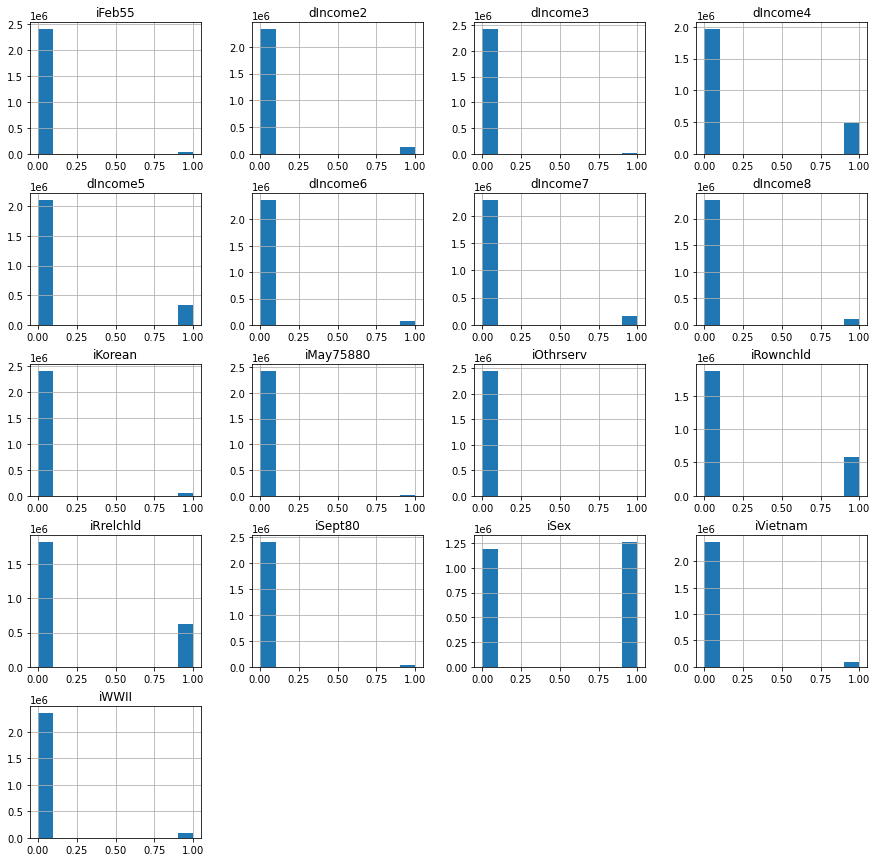

In [36]:
fig = plt.figure(figsize = (15,15))
ax = fig.gca()
tmp.hist(ax = ax)
plt.show()

Widać, że w przypadku tych kolumn wartości są dyskretne: 0 lub 1.